In [1]:
#packages used
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas
import geopy.distance
from gurobipy import *

In [2]:
#Data from https://www.censushardtocountmaps2020.us/ 
df = pandas.read_excel('Hard_To_Count_NY.xlsx','ACS2013-17')
df_percents = pandas.read_excel('Hard_To_Count_NY.xlsx','ACS2013-17_PERCENTS')

In [3]:
Borough_df = df[df.County_name10.isin(['Richmond County', 'Kings County','New York County','Queens County', 'Bronx County'])]
Borough_df_percents = df_percents[df_percents.County_name10.isin(['Richmond County', 'Kings County','New York County','Queens County', 'Bronx County'])]

Borough_df = Borough_df.sort_values(by=['GEOID'])
Borough_df_percents = Borough_df_percents.sort_values(by=['GEOID'])

In [4]:
#load in and filter tracts
tract = gpd.read_file('tl_2018_36_tract/tl_2018_36_tract.shp')
Boroughs = tract[tract.COUNTYFP.isin(['005','047','061','081','085'])]
Boroughs = Boroughs.sort_values(by=['GEOID'])

In [5]:
Boroughs['TotPopACS17'] = Borough_df['TotPopACS17'].values
Boroughs['pct_NoInternet'] = Borough_df_percents['pct_NoInternet'].values
Boroughs['MRR2010'] = Borough_df_percents['MRR2010'].values
Boroughs['pct_Poverty_Less200'] = Borough_df_percents['pct_Poverty_Less200'].values

In [6]:
for i in range(len(Boroughs['MRR2010'].values)):
    if Boroughs['MRR2010'].values[i] > 100:
        Boroughs['MRR2010'].values[i] = 50

In [7]:
Bronx = Boroughs[Boroughs.COUNTYFP == '005']
Kings = Boroughs[Boroughs.COUNTYFP == '047']
NY = Boroughs[Boroughs.COUNTYFP == '061']
Queens = Boroughs[Boroughs.COUNTYFP == '081']
Richmond = Boroughs[Boroughs.COUNTYFP == '085']

In [8]:
Bronx=Bronx[Bronx['ALAND']>0]
Kings=Kings[Kings['ALAND']>0]
NY=NY[NY['ALAND']>0]
Queens=Queens[Queens['ALAND']>0]
Richmond=Richmond[Richmond['ALAND']>0]

In [9]:
# Load and Filter Libraries from https://data.cityofnewyork.us/Business/Library/p4pf-fyc4
libraries = gpd.read_file('Library/geo_export_302bef91-6b6b-4cd1-a7f4-07bbf88d35f6.shp')
Bronx_libraries = libraries[libraries.intersects(Bronx.unary_union)]
Kings_libraries = libraries[libraries.intersects(Kings.unary_union)]
NY_libraries = libraries[libraries.intersects(NY.unary_union)]
Queens_libraries = libraries[libraries.intersects(Queens.unary_union)]
Richmond_libraries = libraries[libraries.intersects(Richmond.unary_union)]

In [10]:
def Plot_Borough(Borough,Borough_libraries,shade,title):
    fig ,ax = plt.subplots(1, figsize=(40,40))
    fig.suptitle(title, fontsize=100)
    Borough.plot(ax=ax, cmap = 'rainbow', column = shade, legend = True)
    Borough_libraries.plot(ax=ax, facecolor='black',markersize=400)
#     for x, y, label in zip(Borough_libraries.geometry.x, Borough_libraries.geometry.y, Borough_libraries.name):
#         ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

In [11]:
Plot_Borough(Bronx, Bronx_libraries,'pct_NoInternet','Bronx')

In [12]:
Plot_Borough(Kings, Kings_libraries,'pct_NoInternet','Kings')

In [13]:
Plot_Borough(NY, NY_libraries,'pct_NoInternet','NY')

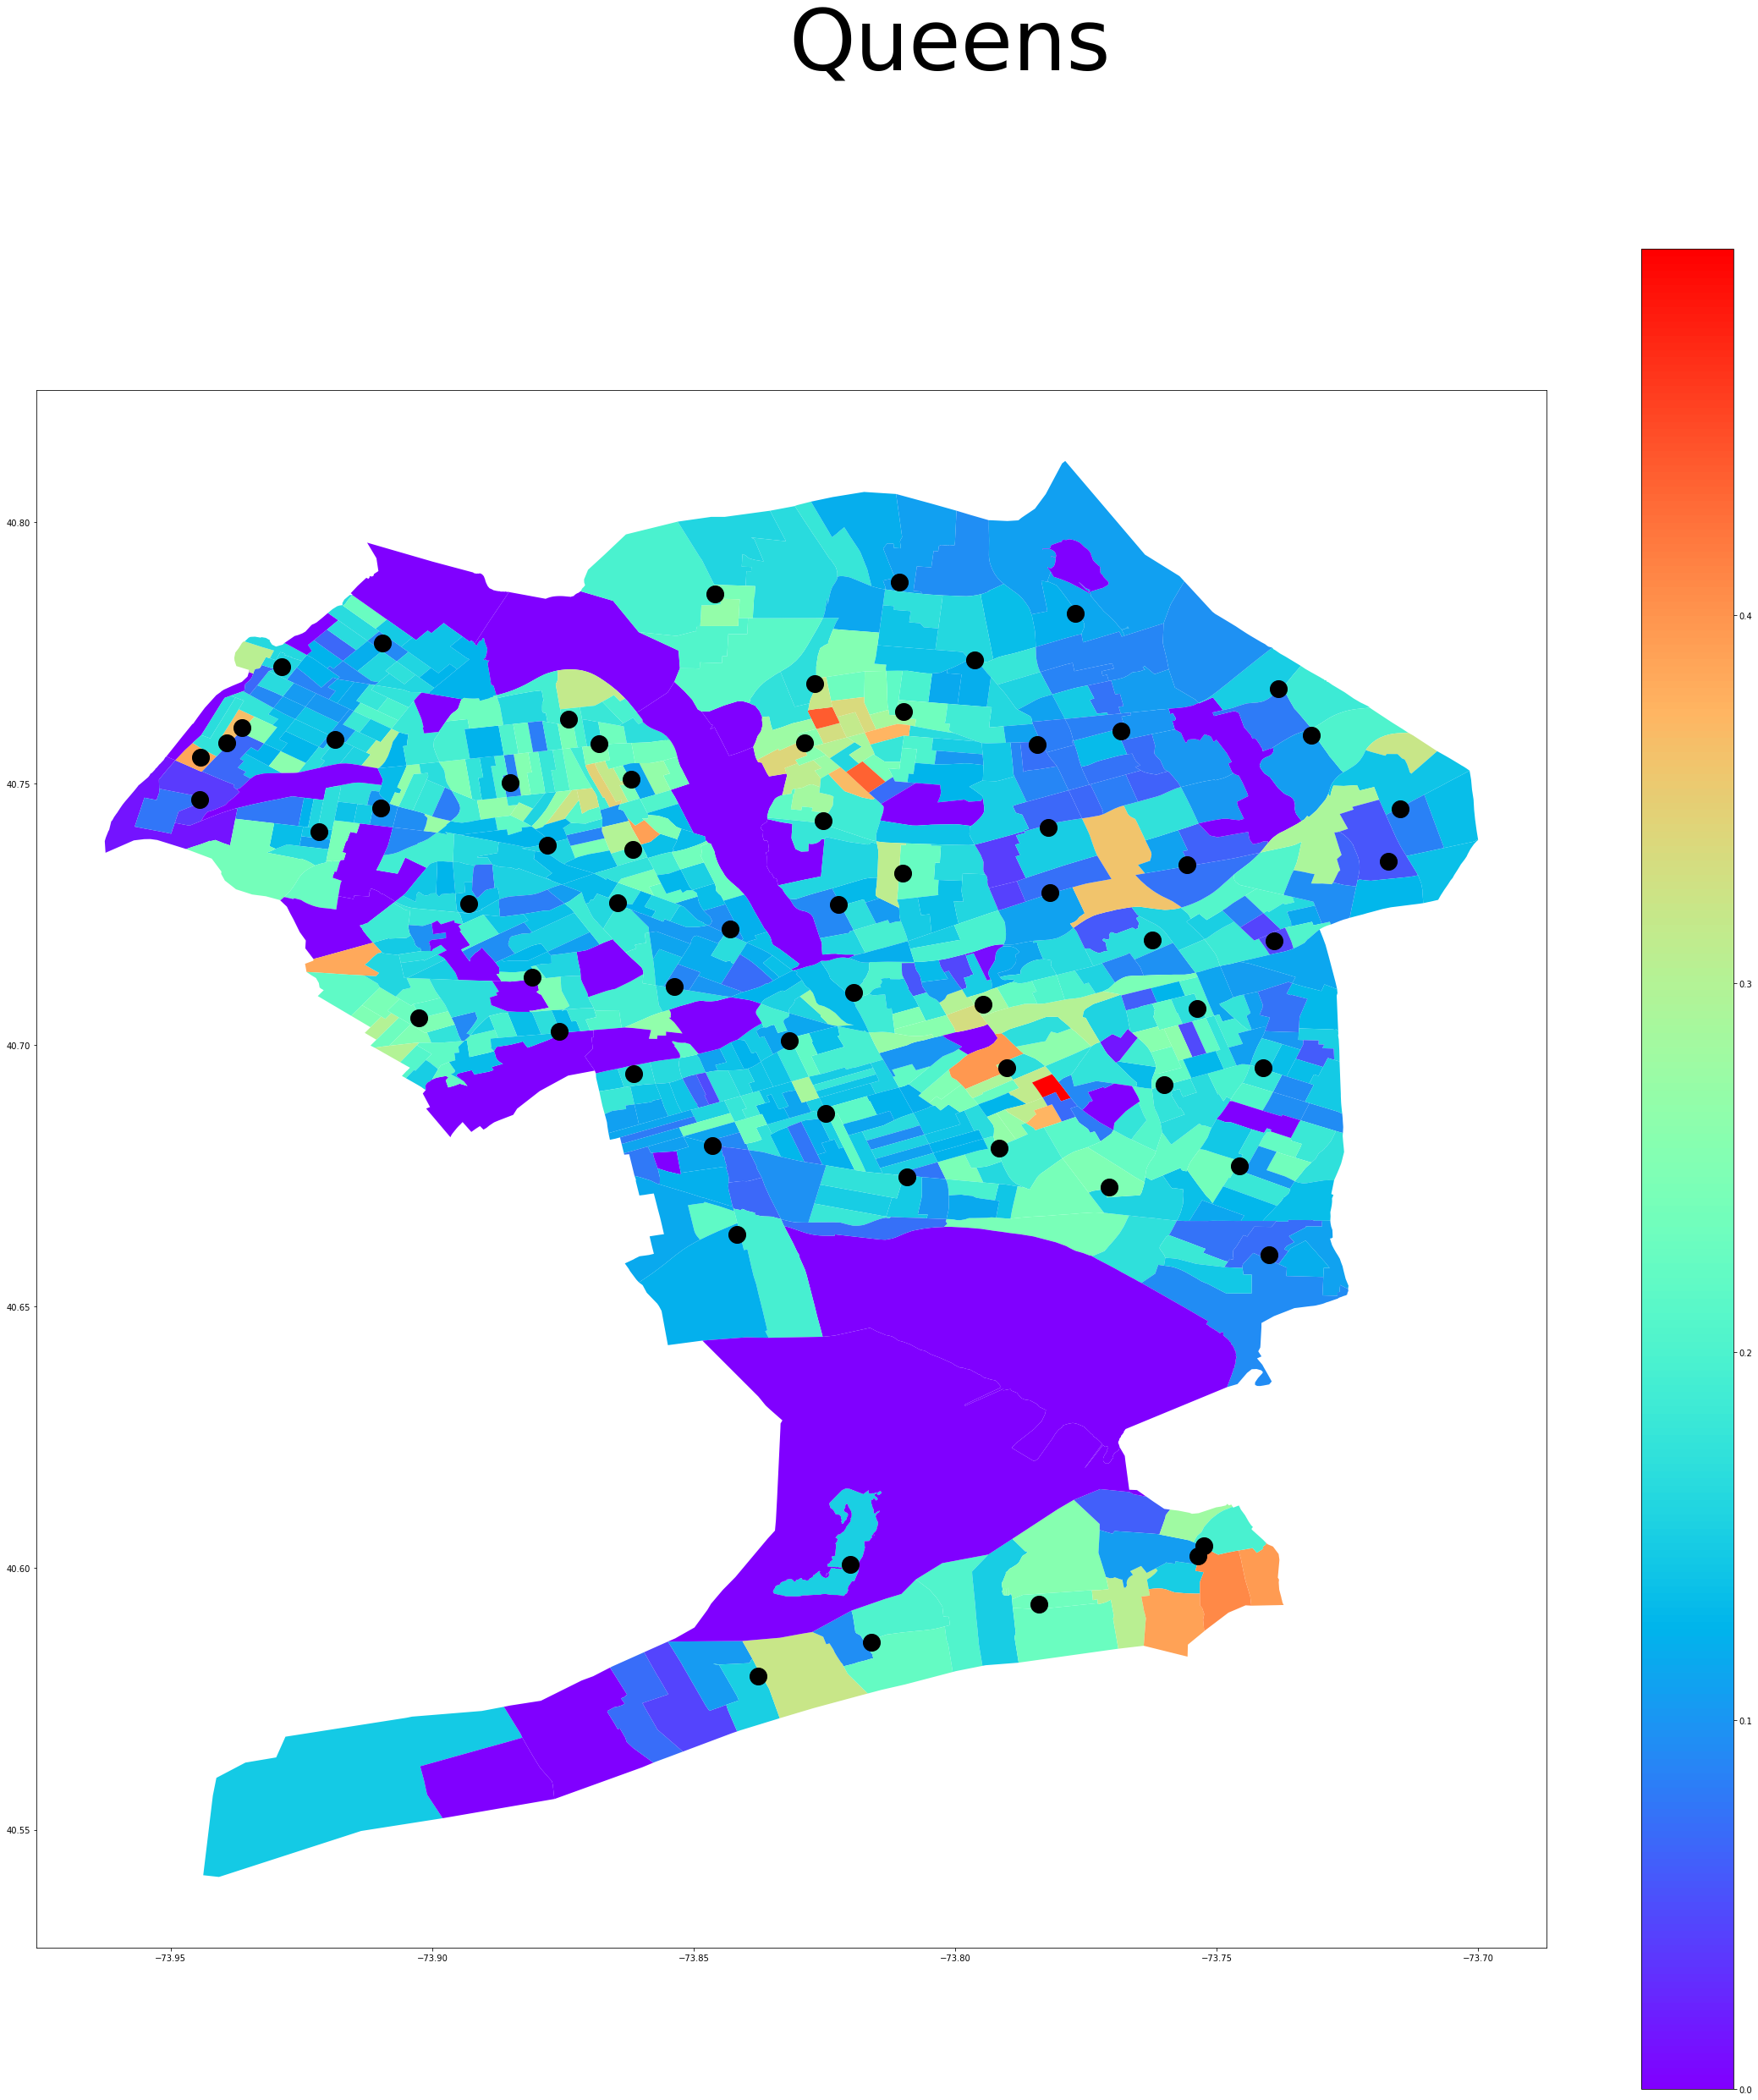

In [14]:
Plot_Borough(Queens, Queens_libraries,'pct_NoInternet','Queens')

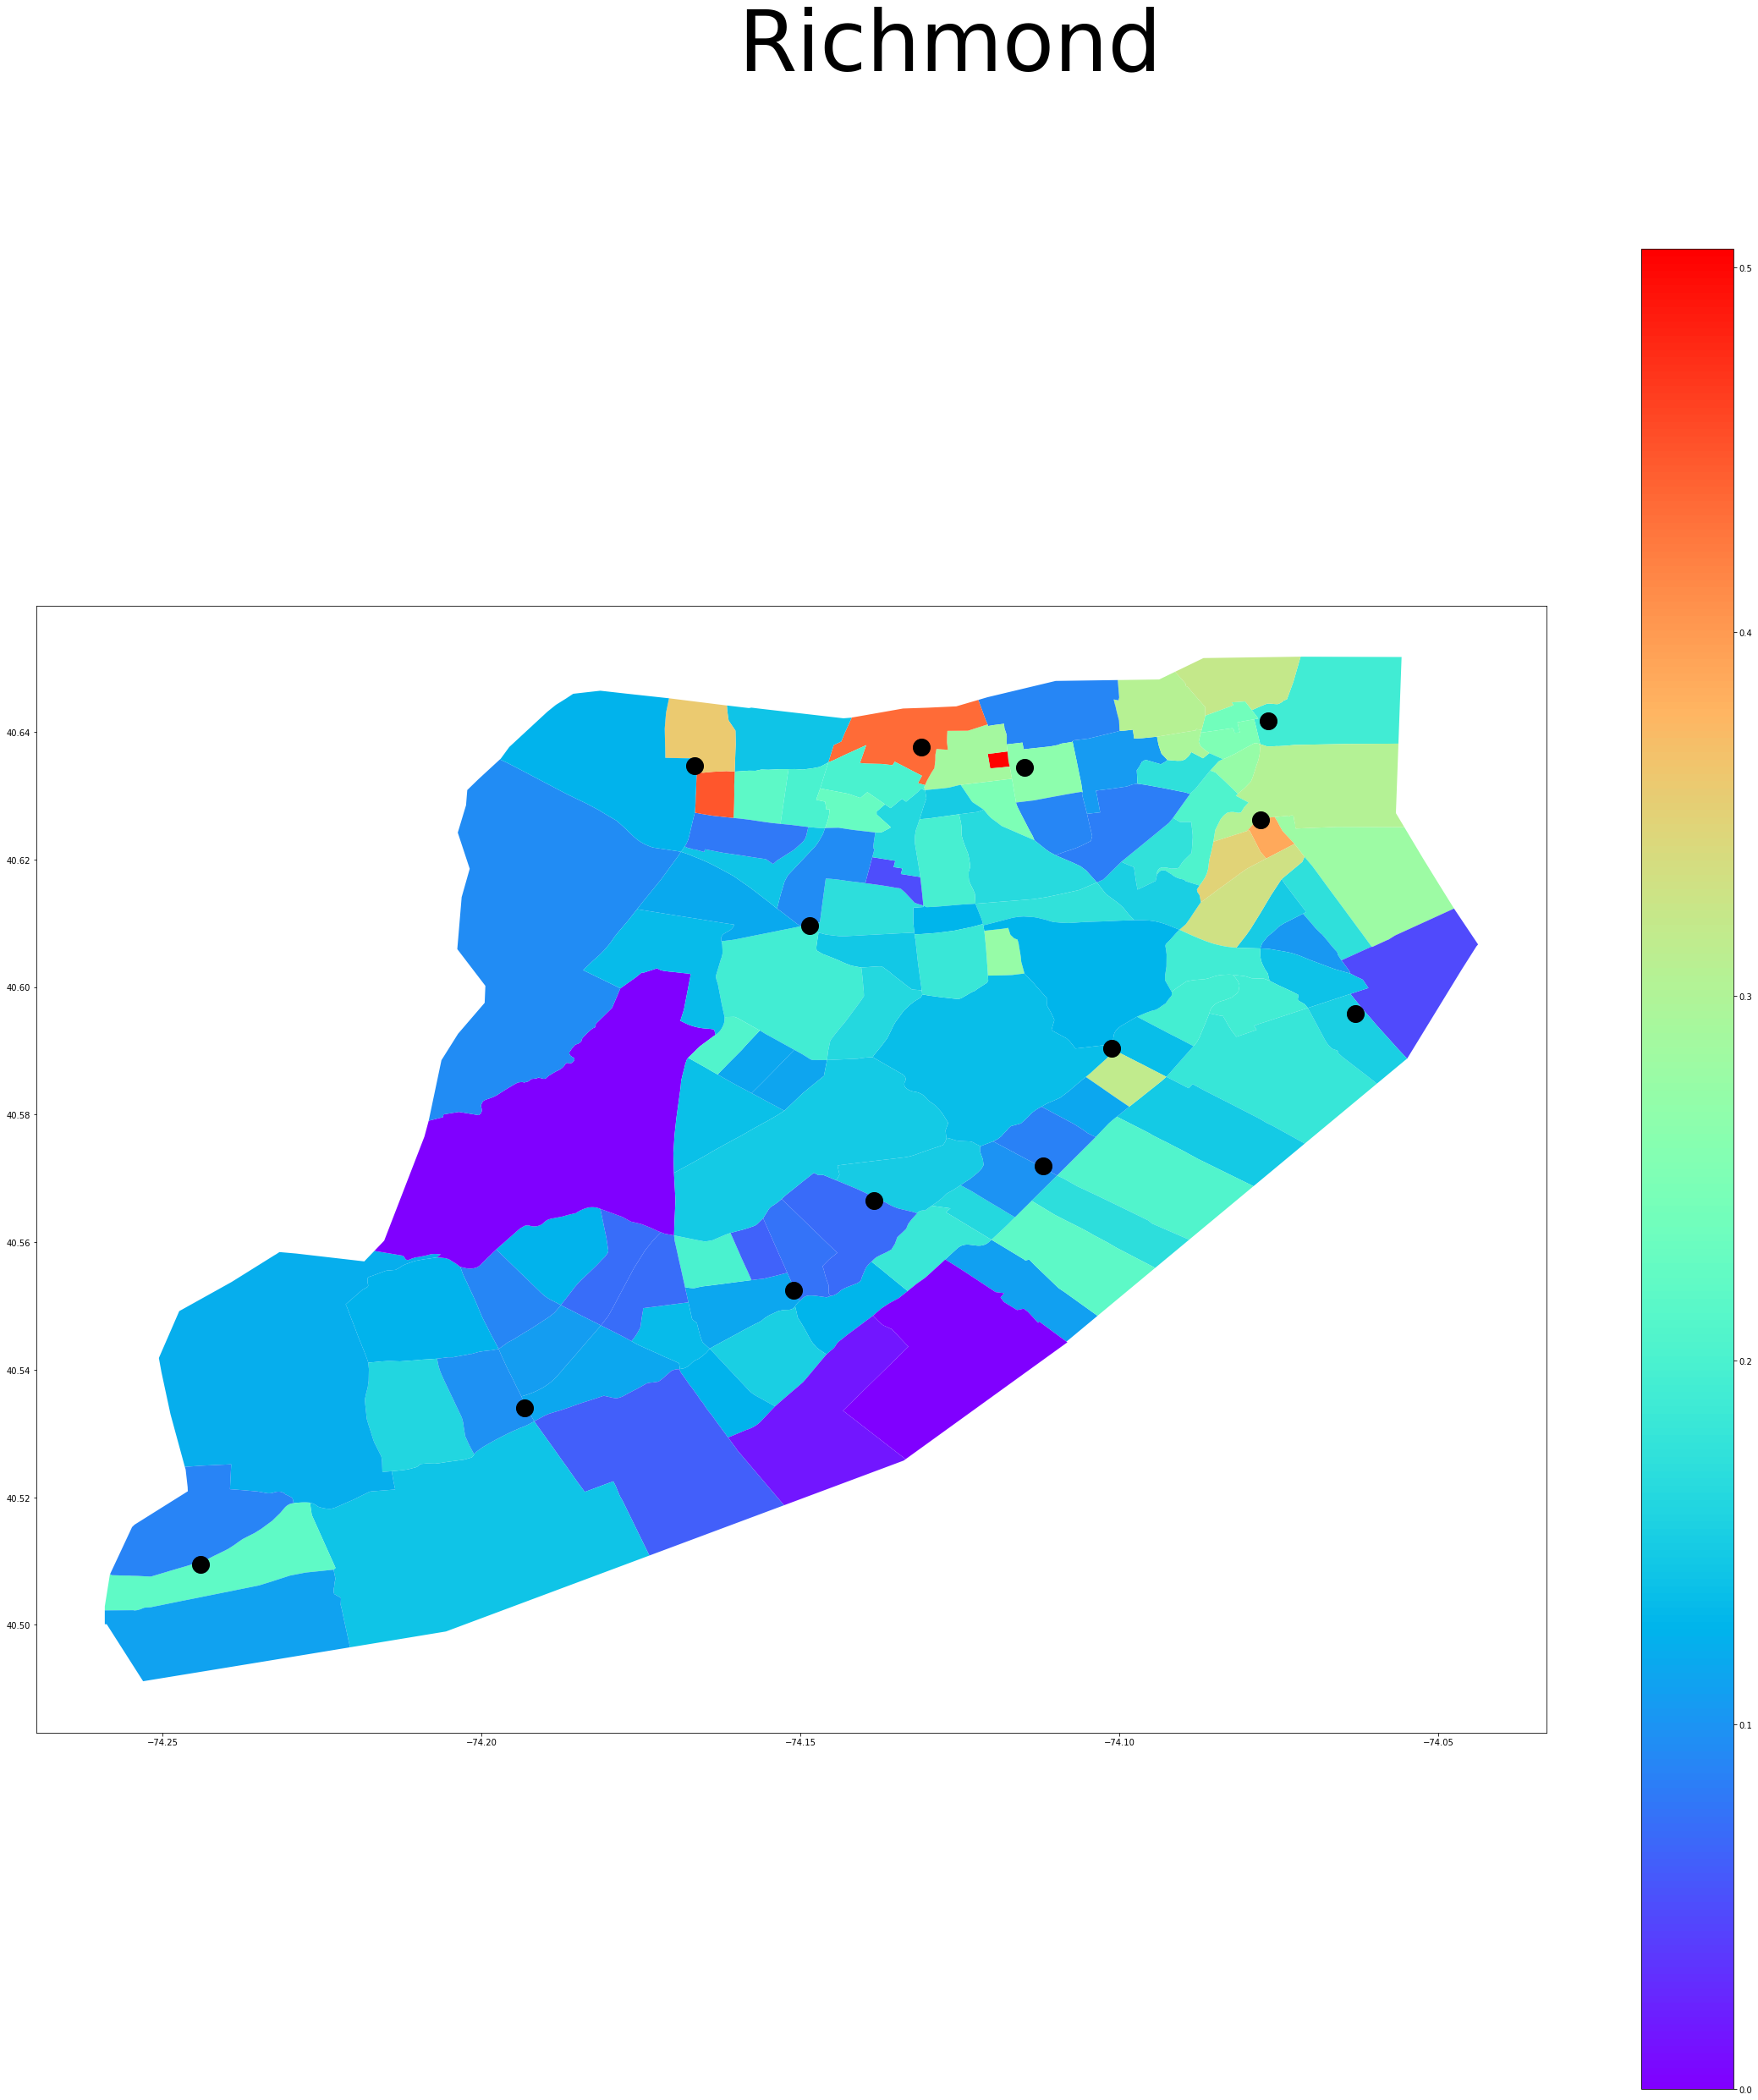

In [15]:
Plot_Borough(Richmond, Richmond_libraries,'pct_NoInternet', 'Richmond')

In [16]:
#Get the distance Matrix for specific Borough and Libraries
def get_distances(Centroids,Borough_libraries):
    D=[]
    for l in Borough_libraries['geometry']:
        A = []
        for p in Centroids['geometry']:
            A.append(p.distance(l))
        D.append(A)
    return(D)

In [17]:
def get_stats(D,values):
    N=[]
    for d in D:
        n=[]
        for idx,dist in enumerate(d):
            n.append(dist*values[idx])
        N.append(n)
    return(N)

In [18]:
Boroughs_Centroids = Boroughs.copy()
Boroughs_Centroids['geometry'] = Boroughs_Centroids['geometry'].centroid

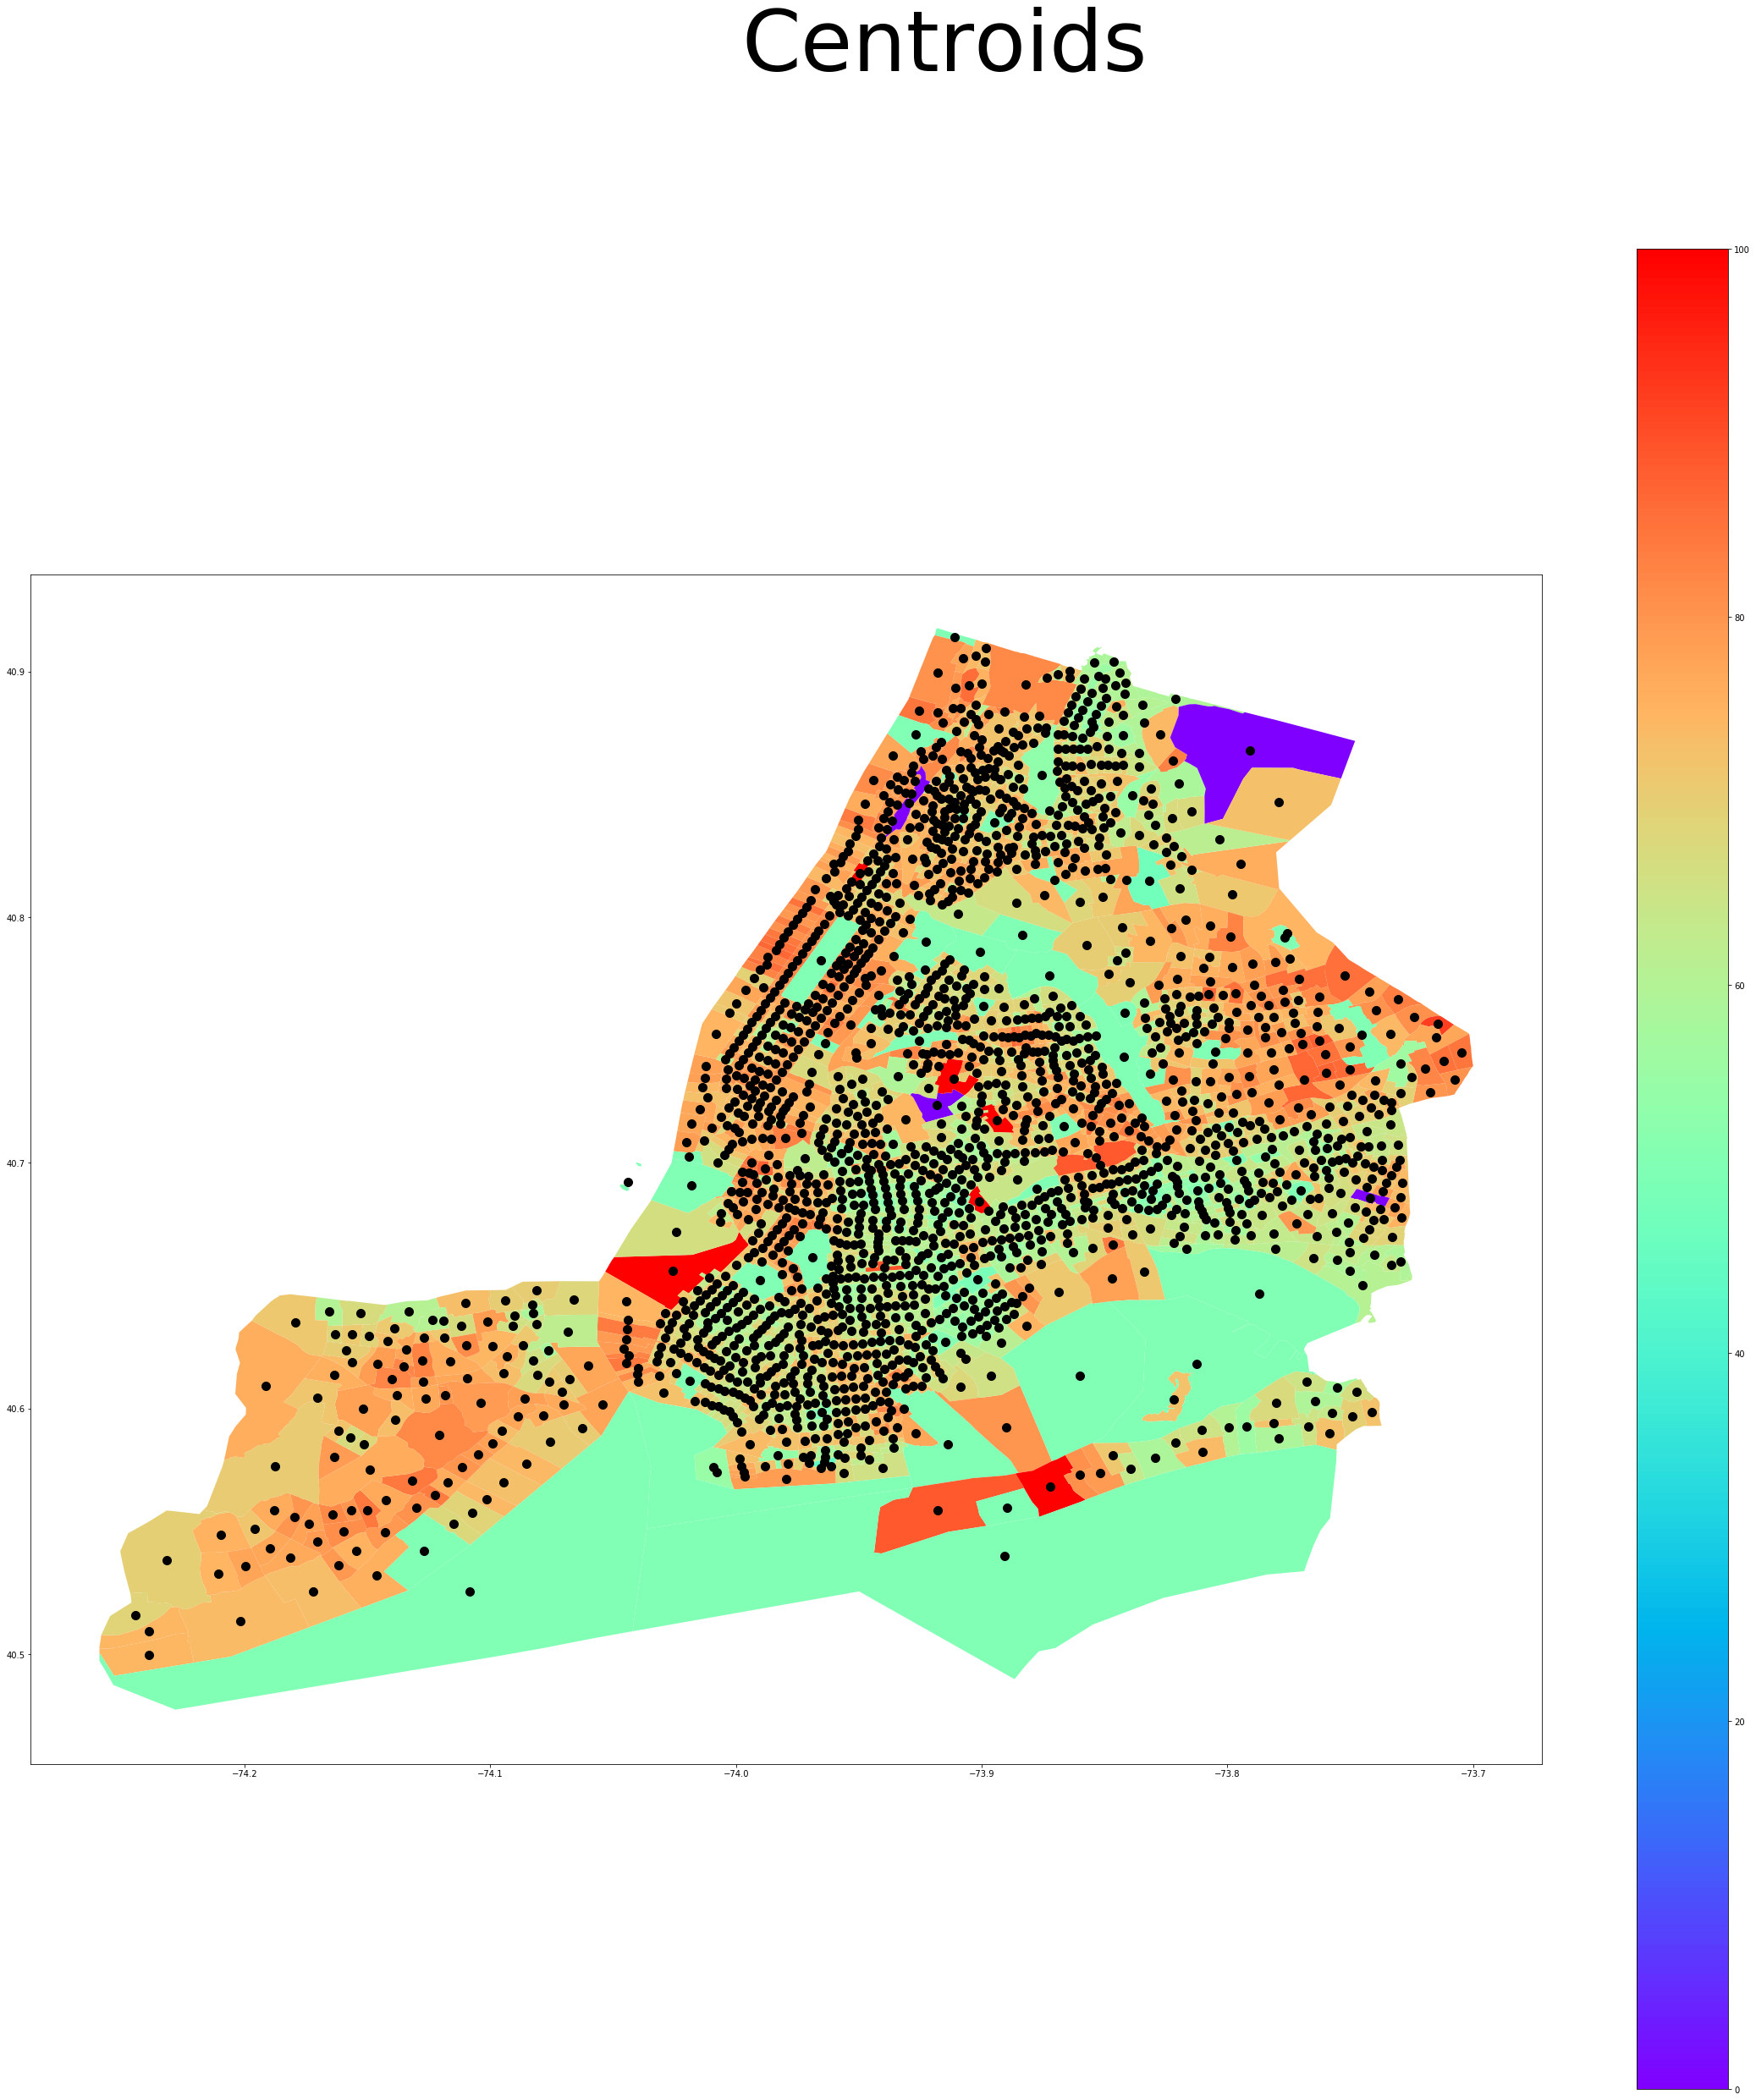

In [19]:
fig ,ax = plt.subplots(1, figsize=(40,40))
fig.suptitle('Centroids', fontsize=100)
Boroughs.plot(ax=ax, cmap = 'rainbow', column = 'MRR2010', legend = True)
Boroughs_Centroids.plot(ax=ax, facecolor='black',markersize=100)

In [20]:
D = get_distances(Boroughs_Centroids, libraries)
N = get_stats(D, Boroughs['TotPopACS17'].values)
P = get_stats(N, Boroughs['pct_NoInternet'].values)
Pov = get_stats(N, Boroughs['pct_Poverty_Less200'].values)
MRR = get_stats(N, Boroughs['MRR2010'].values)

In [21]:
def get_A(D):
    try:

        m = Model("mip1")
        l = len(D)
        t= len(D[0])
        
        #Create the Binary Variables
        A = []
        for i in range(l):
            B=[m.addVar(vtype=GRB.BINARY) for i in range(t)]
            A.append(B)

        #Set objective function
        m.setObjective(sum(A[i][j]*D[i][j] for i in range(l) for j in range(t)), GRB.MINIMIZE)
        
        #Set constraints
        m.addConstrs((sum(A[i][j]
                                   for i in range(l)) == 1
                                   for j in range(t)))
        
        m.optimize()

        C=[]
        for i in range(len(A)):
            c=[]
            for j in range(len(A[0])):
                c.append(A[i][j].x)
            C.append(c)
        return(C)
    
    except AttributeError:
        print('Attribute error')


In [22]:
#Finds the best n libraries based on the objective value attributed to each library
def get_Best_n_Libraries(A,D,n):
    AD = []
    for i in range(len(A)):
        ad = []
        for j in range(len(A[0])):
            ad.append(A[i][j]*D[i][j])
        AD.append(ad)
    sums = []
    for a in AD:
        sums.append(sum(a))
    idxs = sorted(range(len(sums)), key=lambda l: sums[l], reverse = True)
    return(idxs[:n])

In [23]:
def Plot_Borough(Borough,Borough_libraries,shade,title, Chosen_libraries):
    fig ,ax = plt.subplots(1, figsize=(40,40))
    Borough.plot(ax=ax, cmap = 'rainbow', column = shade, legend = True)
    fig.suptitle(title, fontsize=100)
    Borough_libraries.plot(ax=ax, facecolor='black',markersize=400)
    Chosen_libraries.plot(ax=ax, facecolor='red', markersize=400)

In [24]:
# Just Distance
A = get_A(D)
selected_libraries = get_Best_n_Libraries(A,D,90)
Chosen_libraries=libraries.iloc[selected_libraries,:]

Academic license - for non-commercial use only
Optimize a model with 2167 rows, 468072 columns and 468072 nonzeros
Variable types: 0 continuous, 468072 integer (468072 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 6e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 299.0157327
Presolve removed 2167 rows and 468072 columns
Presolve time: 0.88s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.98 seconds
Thread count was 1 (of 8 available processors)

Solution count 2: 16.3015 299.016 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.630146437463e+01, best bound 1.630146437463e+01, gap 0.0000%


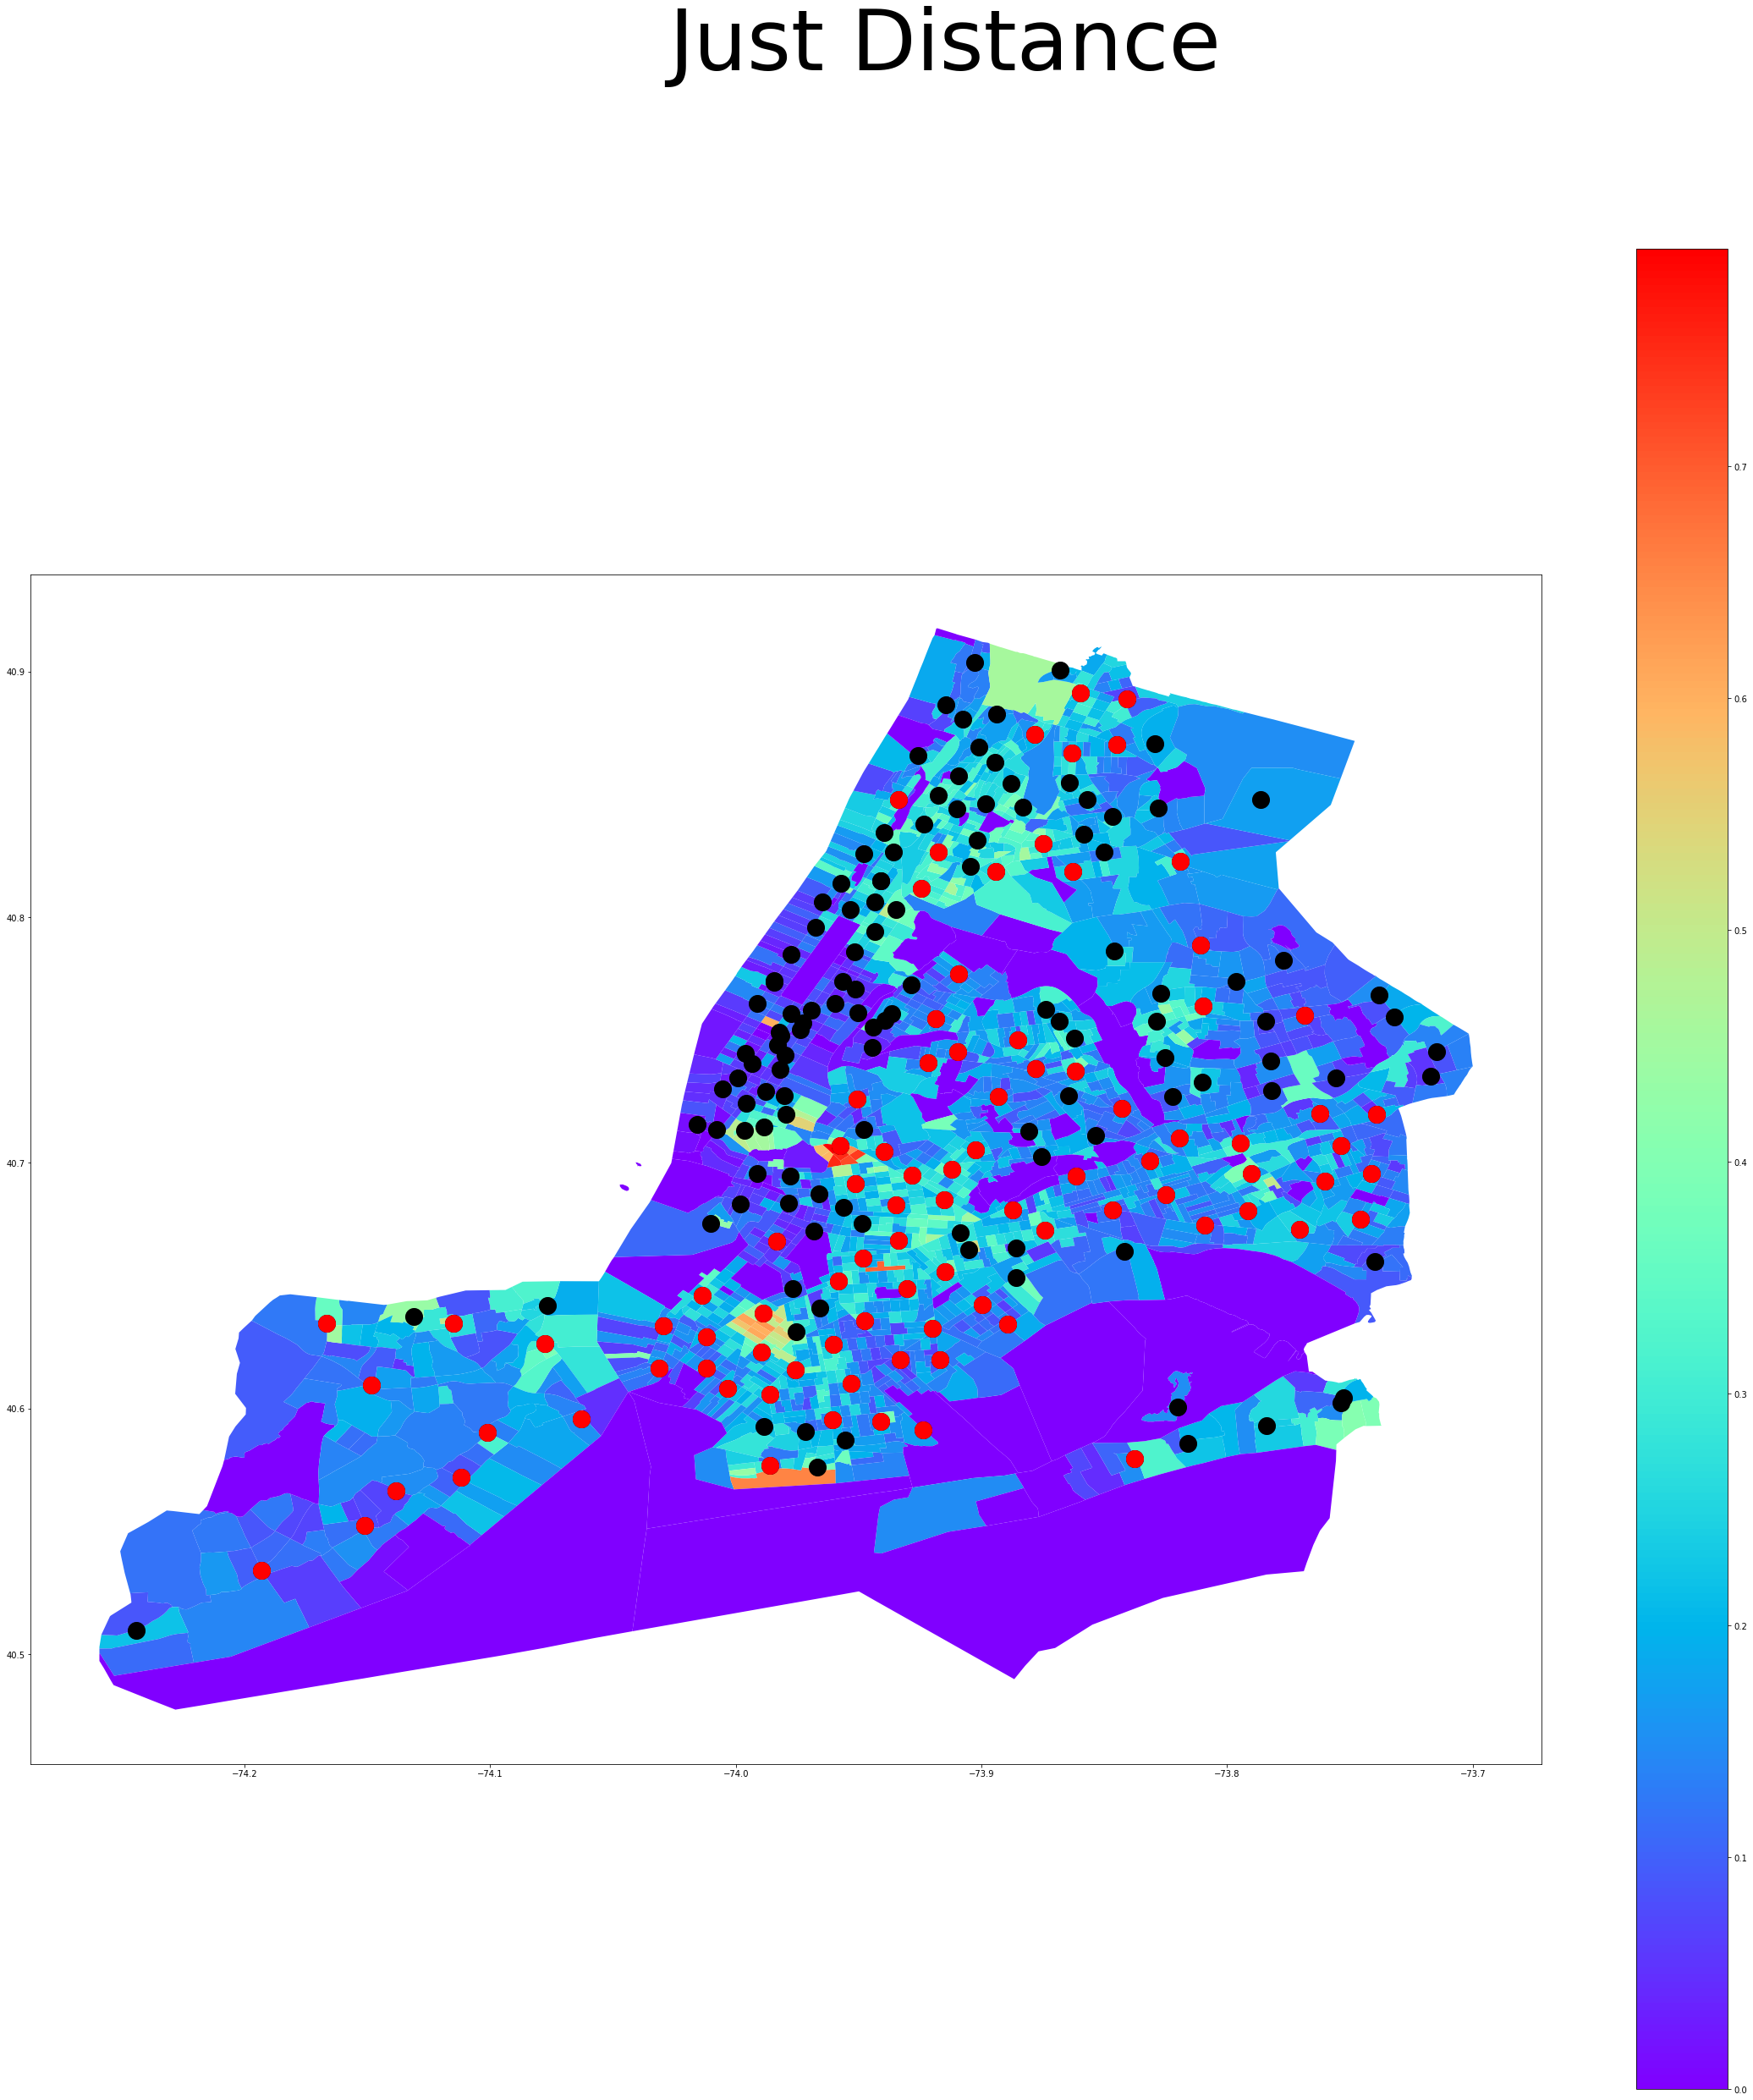

In [25]:
Plot_Borough(Boroughs,libraries,'pct_NoInternet','Just Distance', Chosen_libraries)

In [26]:
# Distance + Population
A = get_A(N)
selected_libraries = get_Best_n_Libraries(A,N,90)
Chosen_libraries=libraries.iloc[selected_libraries,:]

Optimize a model with 2167 rows, 468072 columns and 468072 nonzeros
Variable types: 0 continuous, 468072 integer (468072 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-02, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1111366.2989
Presolve removed 2167 rows and 468072 columns
Presolve time: 0.96s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 1.06 seconds
Thread count was 1 (of 8 available processors)

Solution count 2: 60546.1 1.11137e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.054613179150e+04, best bound 6.054613179150e+04, gap 0.0000%


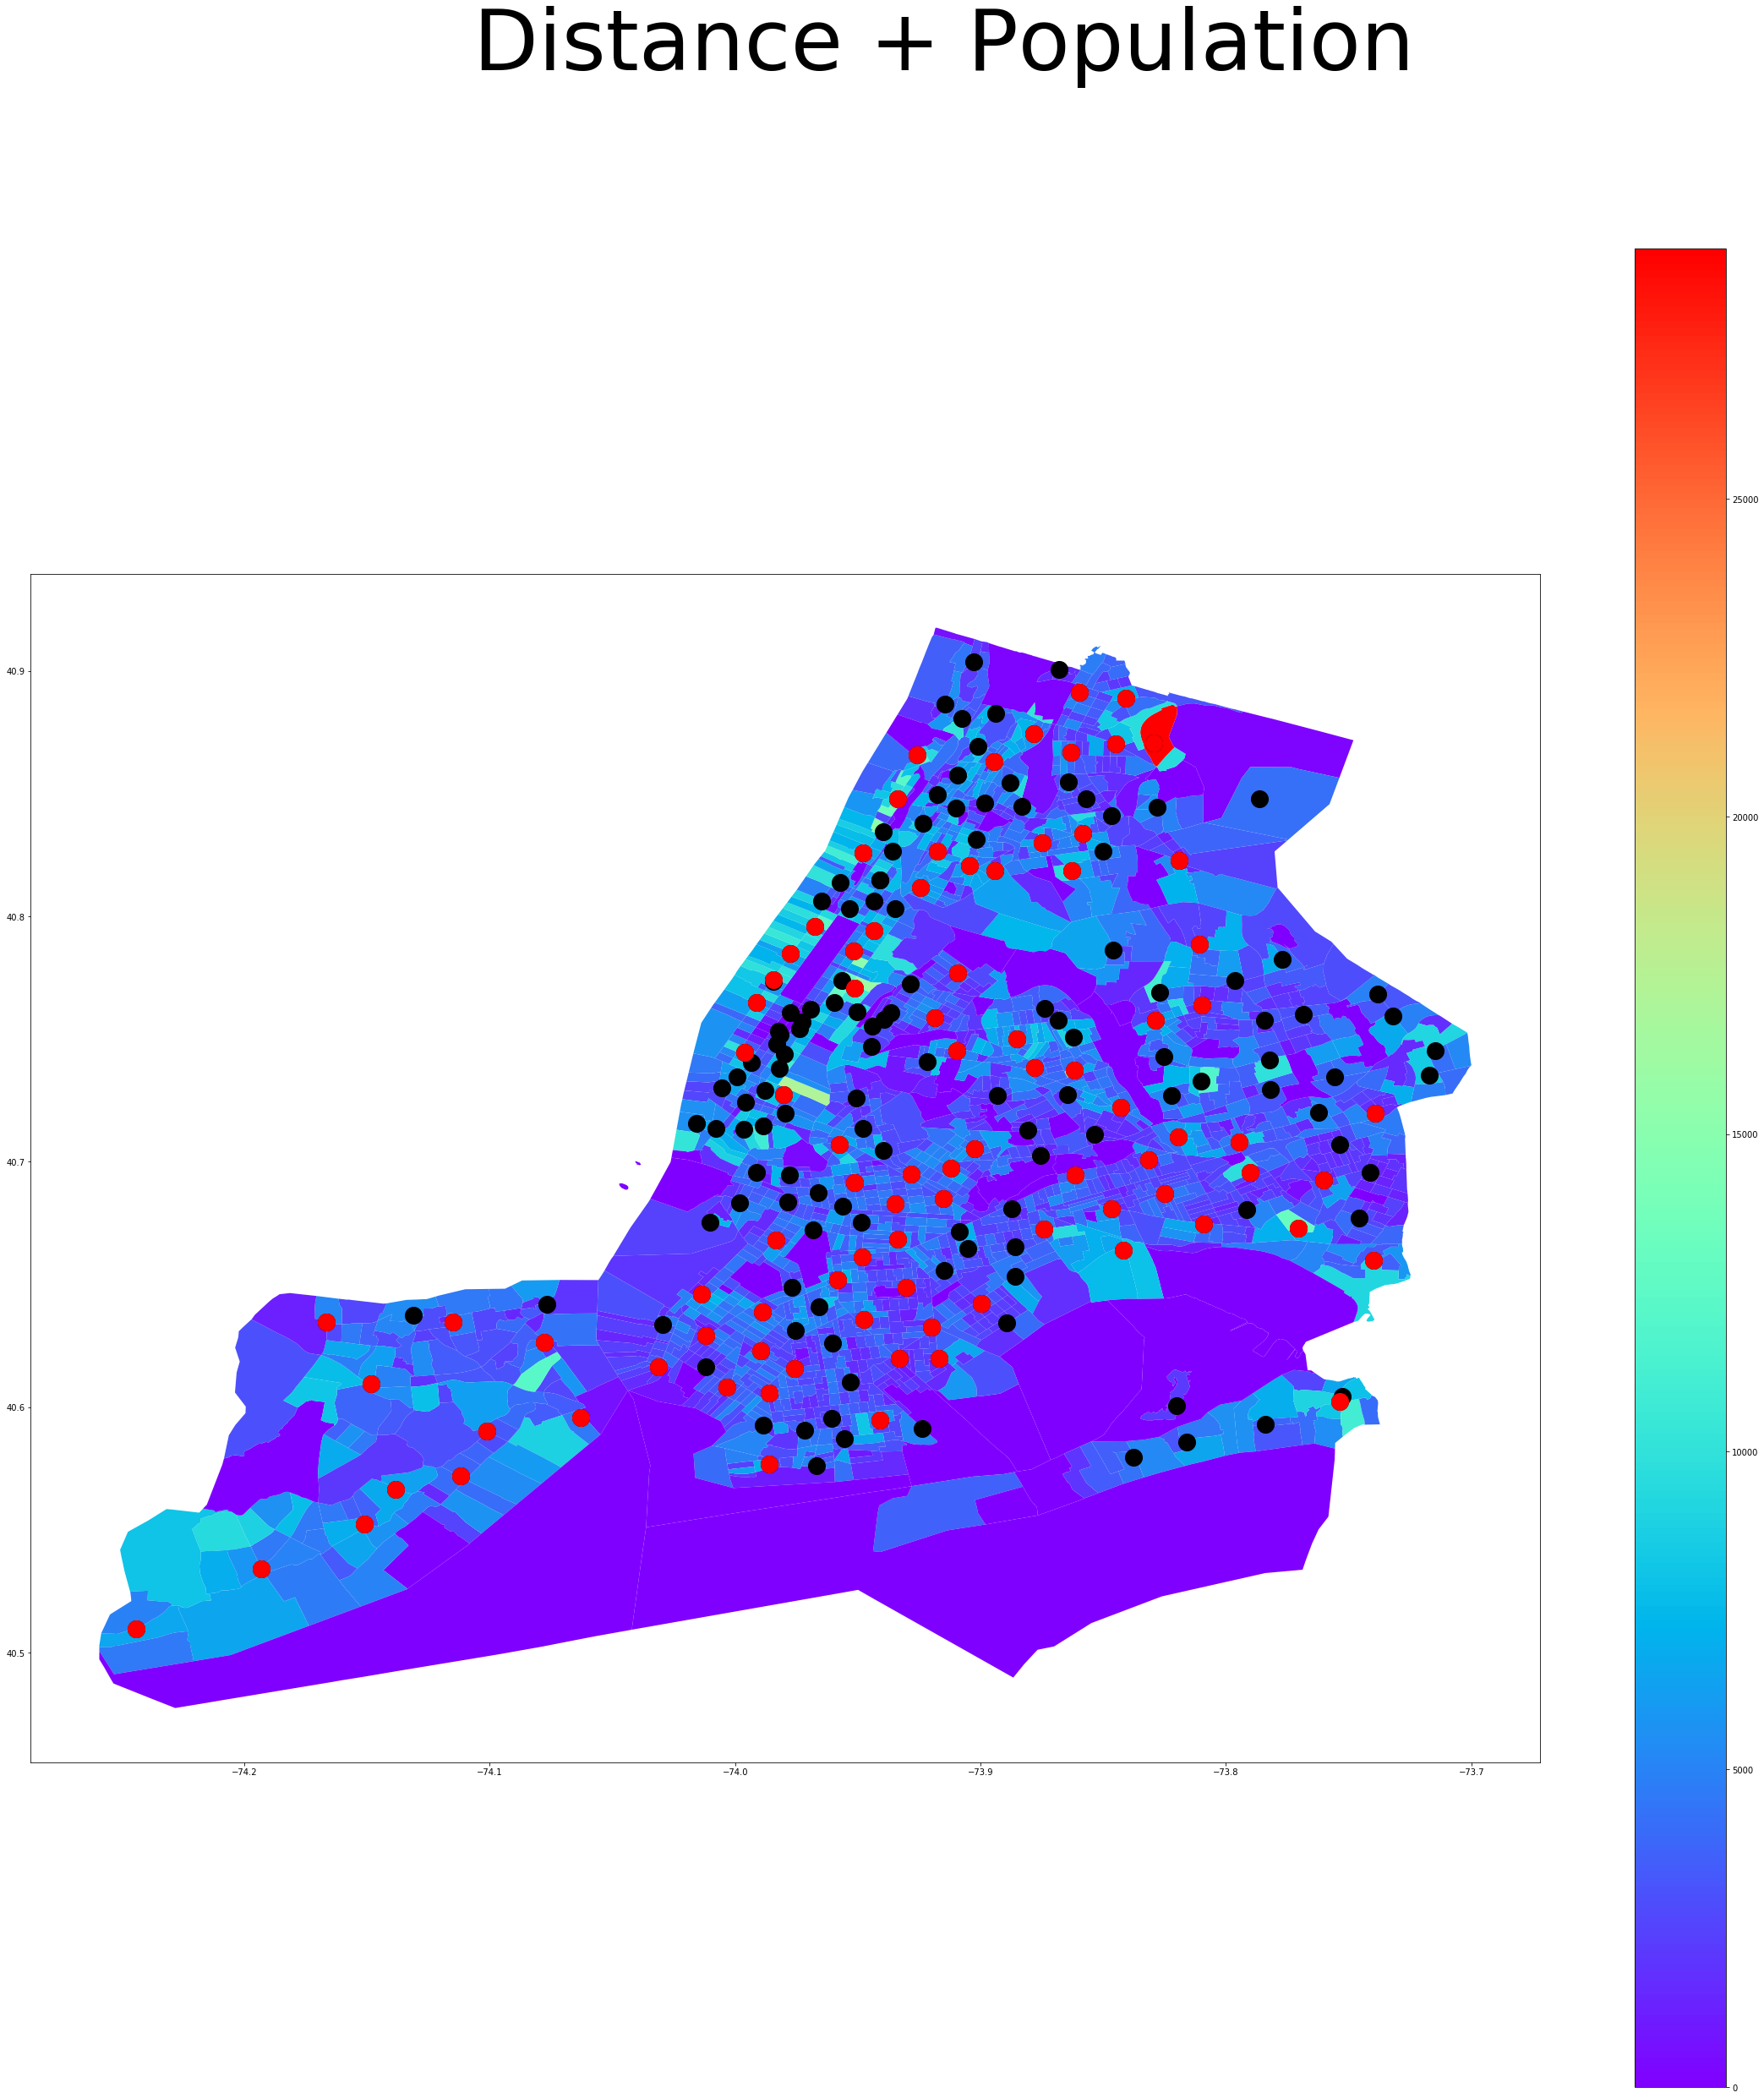

In [27]:
Plot_Borough(Boroughs,libraries,'TotPopACS17','Distance + Population', Chosen_libraries)

In [28]:
# Distance + Population + PctNoInternet
A = get_A(MRR)
selected_libraries = get_Best_n_Libraries(A,MRR,90)
Chosen_libraries=libraries.iloc[selected_libraries,:]

Optimize a model with 2167 rows, 468072 columns and 468072 nonzeros
Variable types: 0 continuous, 468072 integer (468072 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 7.717853e+07
Presolve removed 2167 rows and 468072 columns
Presolve time: 1.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 1.10 seconds
Thread count was 1 (of 8 available processors)

Solution count 2: 4.25188e+06 7.71785e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.251881743366e+06, best bound 4.251881743366e+06, gap 0.0000%


In [29]:
Plot_Borough(Boroughs,libraries,'MRR2010','Distance + Population + MRR2010', Chosen_libraries)

In [30]:
# Distance + Population + PctNoInternet
A = get_A(P)
selected_libraries = get_Best_n_Libraries(A,P,90)
Chosen_libraries=libraries.iloc[selected_libraries,:]

Optimize a model with 2167 rows, 468072 columns and 468072 nonzeros
Variable types: 0 continuous, 468072 integer (468072 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 213998.66387
Presolve removed 2167 rows and 468072 columns
Presolve time: 0.82s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.92 seconds
Thread count was 1 (of 8 available processors)

Solution count 2: 11404.6 213999 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.140462936801e+04, best bound 1.140462936801e+04, gap 0.0000%


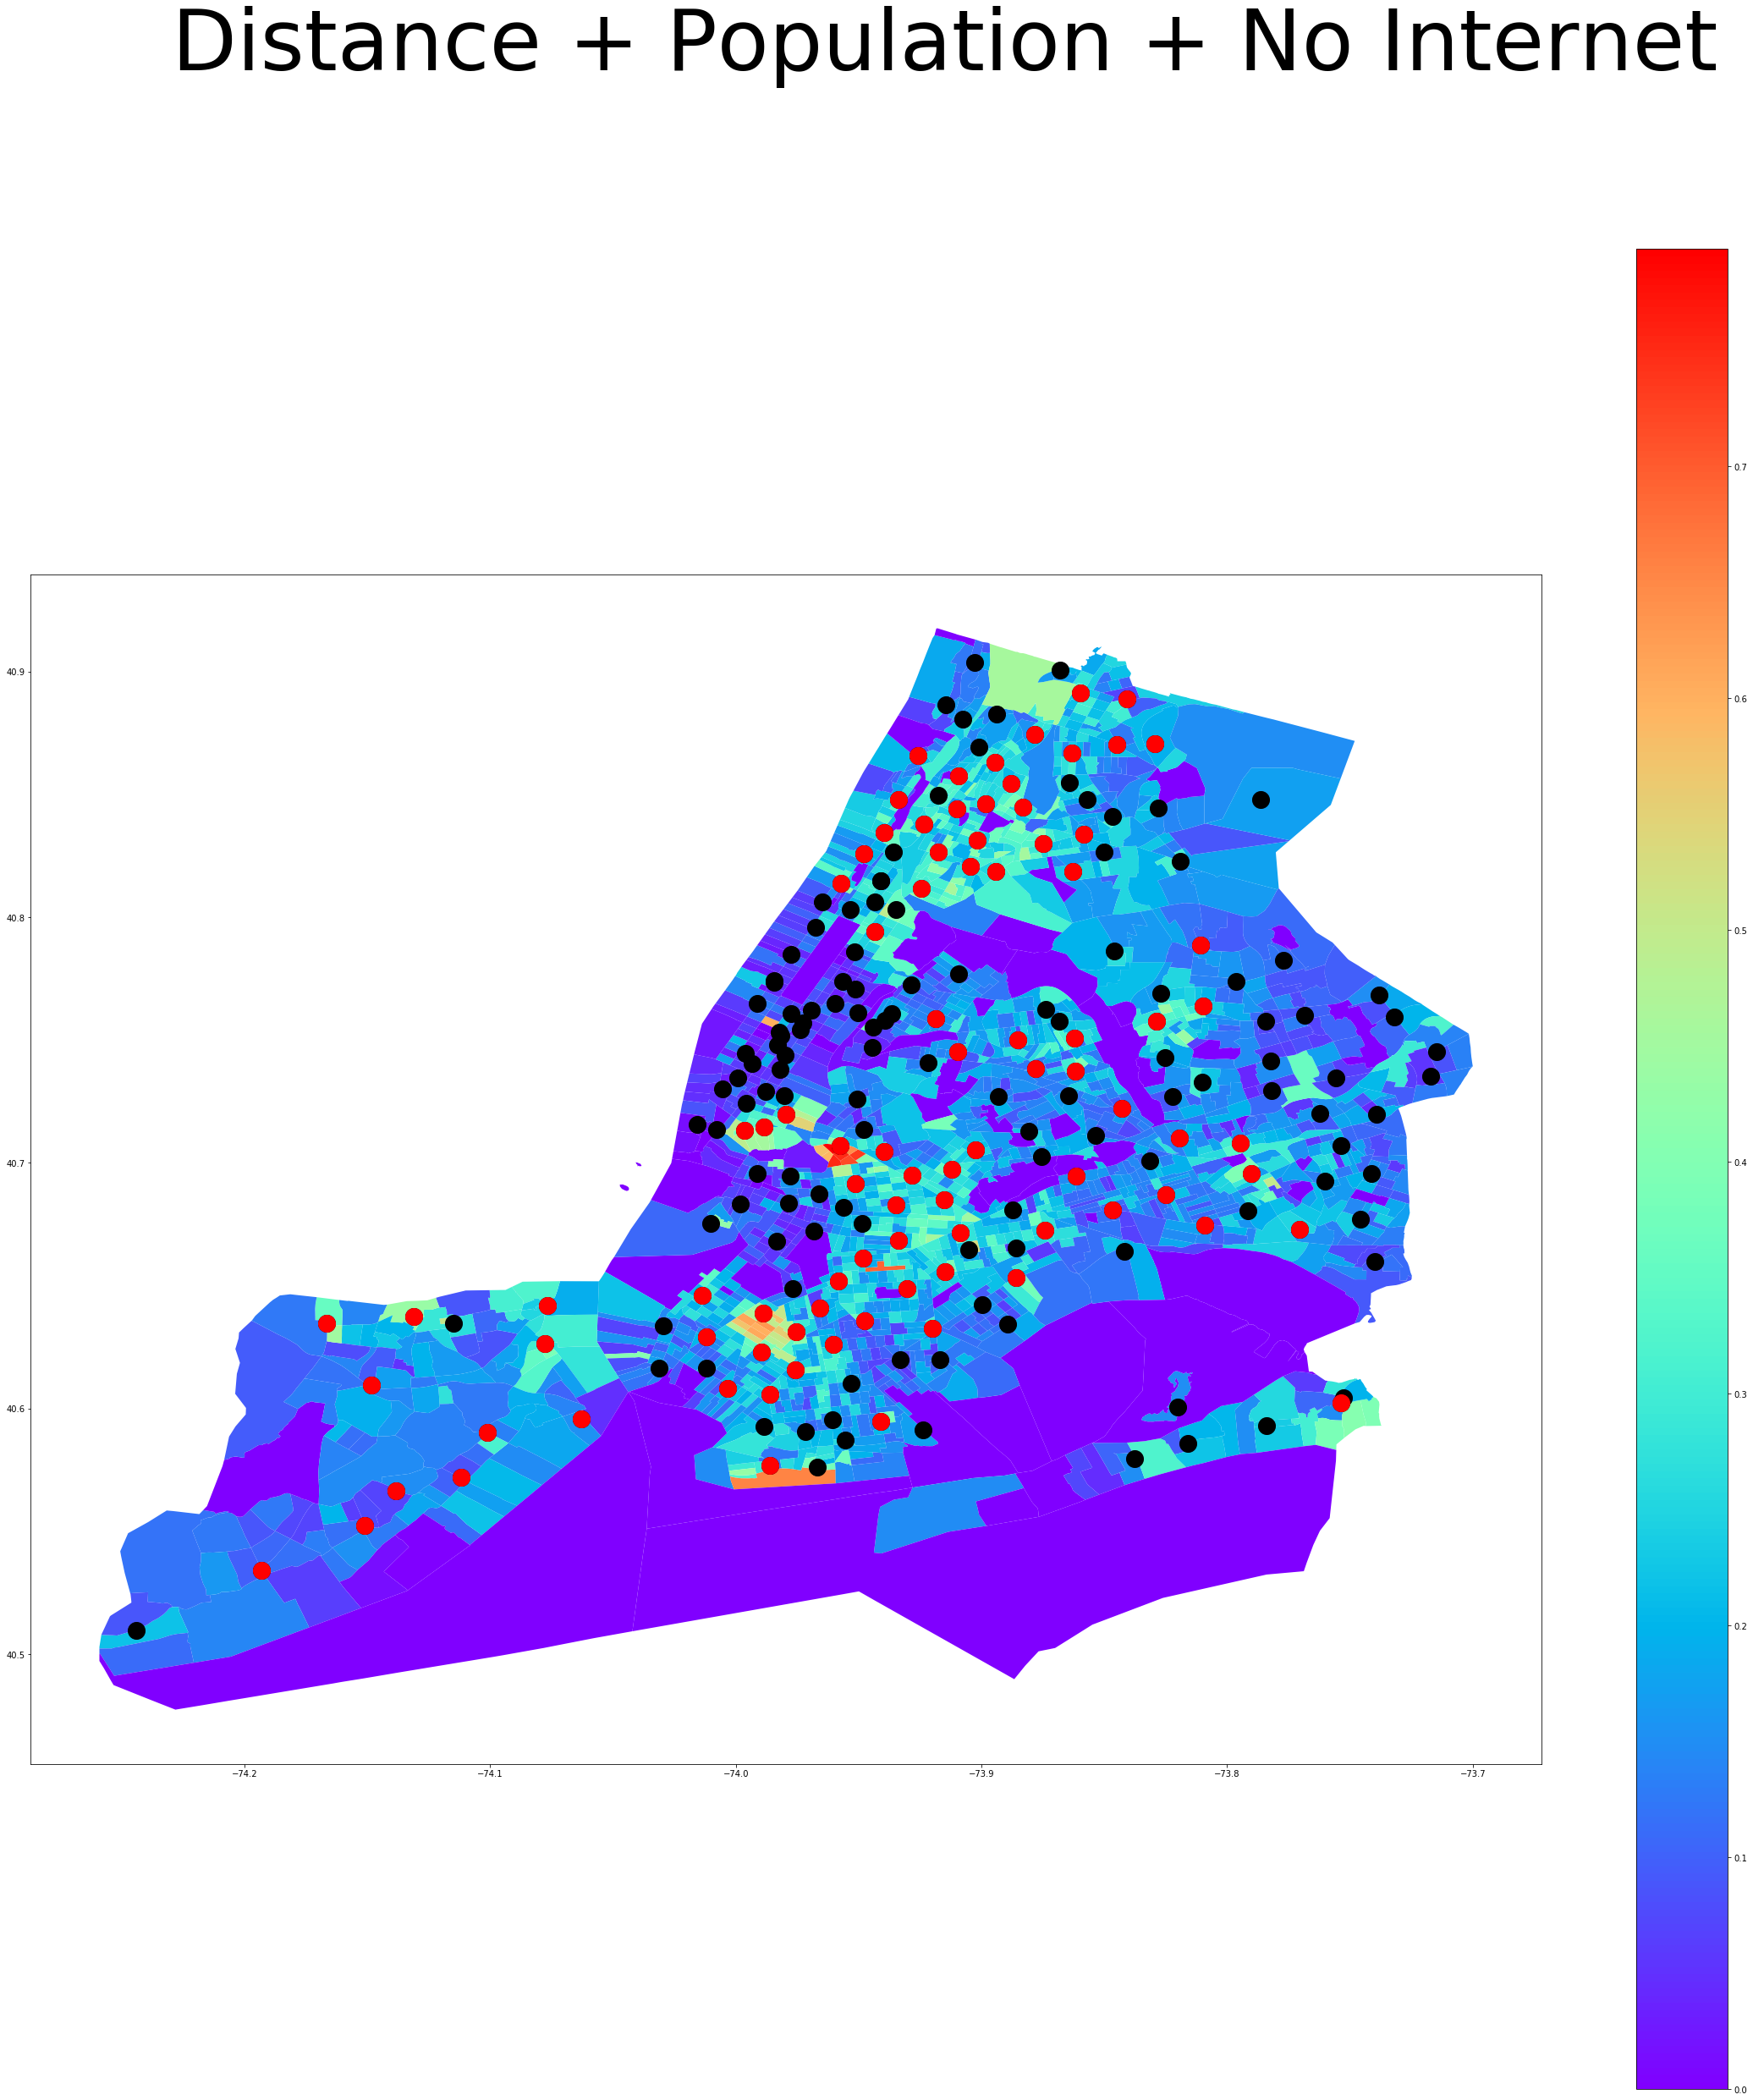

In [31]:
Plot_Borough(Boroughs,libraries,'pct_NoInternet','Distance + Population + No Internet', Chosen_libraries)

In [32]:
# Distance + Population + Poverty 200%
A = get_A(Pov)
selected_libraries = get_Best_n_Libraries(A,Pov,90)
Chosen_libraries=libraries.iloc[selected_libraries,:]

Optimize a model with 2167 rows, 468072 columns and 468072 nonzeros
Variable types: 0 continuous, 468072 integer (468072 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-02, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 404476.25570
Presolve removed 2167 rows and 468072 columns
Presolve time: 1.04s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 1.14 seconds
Thread count was 1 (of 8 available processors)

Solution count 2: 22047.8 404476 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.204781874069e+04, best bound 2.204781874069e+04, gap 0.0000%


In [33]:
Plot_Borough(Boroughs,libraries,'pct_Poverty_Less200','Distance + Population + Poverty 200%', Chosen_libraries)